In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import OneHotEncoder

<b>Import Data</b>

In [2]:
cdf = pd.read_csv("Customers.csv")
tdf = pd.read_csv("Transactions.csv")

<b>Data Preprocessing</b>

In [3]:
customer_transactions = tdf.groupby("CustomerID").agg(
    TotalSpent=("TotalValue", "sum"),
    AvgTransactionValue=("TotalValue", "mean"),
    PurchaseCount=("TransactionID", "count"),
    UniqueProducts=("ProductID", "nunique")
).reset_index()

customer_profiles = pd.merge(cdf, customer_transactions, on="CustomerID", how="left").fillna(0)

encoder = OneHotEncoder(sparse_output=False, drop="first")
region_encoded = encoder.fit_transform(customer_profiles[["Region"]])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(["Region"]))

customer_profiles = pd.concat([customer_profiles, region_df], axis=1).drop(columns=["Region", "CustomerName", "SignupDate"])

In [4]:
customer_profiles.head()

,CustomerID,TotalSpent,AvgTransactionValue,PurchaseCount,UniqueProducts,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,670.904,5.0,5.0,0.0,0.0,1.0
1,C0002,1862.74,465.685,4.0,4.0,0.0,0.0,0.0
2,C0003,2725.38,681.345,4.0,4.0,0.0,0.0,1.0
3,C0004,5354.88,669.360,8.0,8.0,0.0,0.0,1.0
4,C0005,2034.24,678.080,3.0,3.0,0.0,0.0,0.0


<b>Key Metrics:</b>
    
TotalSpent: Total money spent by the customer.<br>
AvgTransactionValue: How much they spend per transaction.<br>
PurchaseCount: Number of transactions they made.<br>
UniqueProducts: The variety of products they buy.<br>


Region is categorical and must be converted into numerical features using one-hot encoding.

Standardization is important because clustering algorithms like K-Means are sensitive to scale.<br>
Features like TotalSpent may have much larger values, affecting clustering quality.

<b>PCA</b>

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_profiles.drop(columns=["CustomerID"]))
customer_profiles_pca = pd.DataFrame(pca_features, columns=["PCA1", "PCA2"])

<b>Kmeans Clustering Using Elbow Method</b>

D:\APP\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\APP\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\APP\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\APP\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

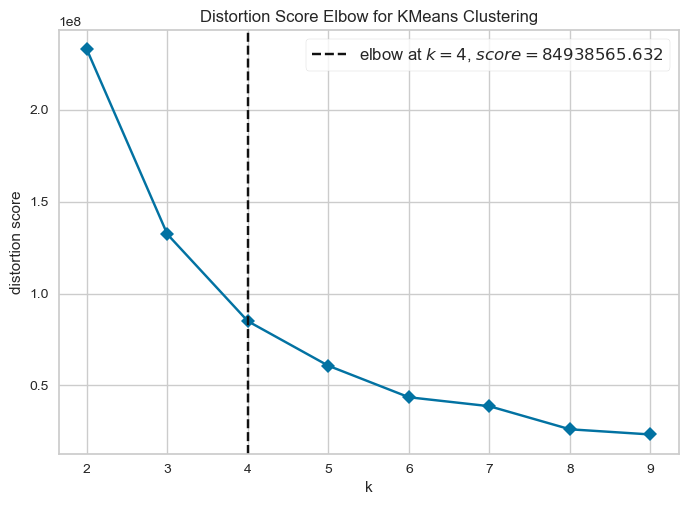

D:\APP\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [6]:
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(customer_profiles_pca)
visualizer.show()

optimal_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_profiles_pca["Cluster"] = kmeans.fit_predict(customer_profiles_pca)

We apply K-Means clustering using the optimal number of clusters.<br>
The Elbow Method helps us decide the optimal number of clusters.<br>
The point where the "elbow" appears in the plot is the best choice.<br>

<b>Davies-Bouldin Index</b>

In [7]:
db_index = davies_bouldin_score(customer_profiles_pca.drop(columns=["Cluster"]), customer_profiles_pca["Cluster"])
sil_score = silhouette_score(customer_profiles_pca.drop(columns=["Cluster"]), customer_profiles_pca["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Index: 0.6030182263437911
Silhouette Score: 0.4973124195190688


DB Index evaluates cluster quality (lower is better).<br>
It is based on intra-cluster distances (compactness) and inter-cluster distances (separation).

Silhouette Score gives an additional measure of cluster separation.<br>
Measures how similar a point is to its own cluster compared to other clusters

Both metrics suggest that clustering is decent, but not perfect.<br> 
Clusters are somewhat well-separated, but might have areas where points from different clusters are close to each other

<b>Visualization</b>

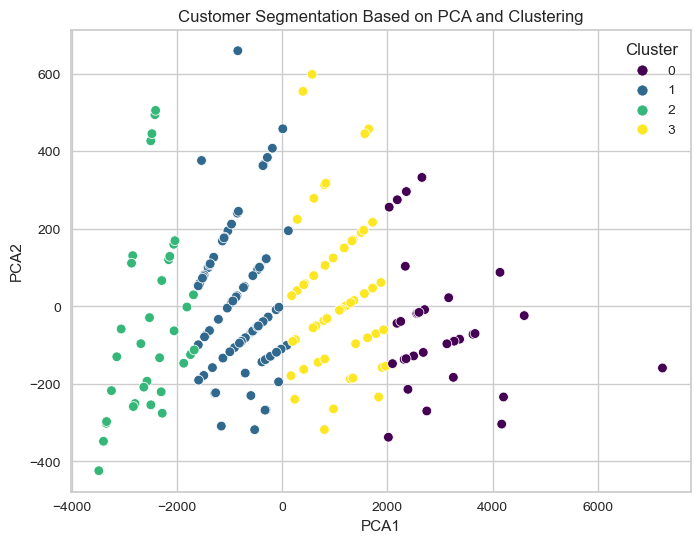

In [8]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_profiles_pca["PCA1"], y=customer_profiles_pca["PCA2"], hue=customer_profiles_pca["Cluster"], palette="viridis")
plt.title("Customer Segmentation Based on PCA and Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.show()